In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
problems = [
    ("Forrester", {}),
    ("Levy", {}),
    ("Hartmann6", {})
]

methods = {
    #"EI": "EI",
    #"UCB": "UCB",
    #"EICostRatio": "EICostRatio",
    #"UCBCostRatio": "UCBCostRatio"
    #"HardLocalPenalisationBatchBOCost": "HardLocalPenalisationBatchBOCost",
    "LocalPenalisationBatchBOCost": "LocalPenalisationBatchBOCost"
}

bo_names = {
    #"EI": "AsyncBO",
    #"UCB": "AsyncBO",
    #"EICostRatio": "AsyncCostAcqBO",
    #"UCBCostRatio": "AsyncCostAcqBO",
    "HardLocalPenalisationBatchBOCost": "AsyncSKBO",
    "LocalPenalisationBatchBOCost": "AsyncSKBO"
}

killing_names = [
    "NoKilling",
    "DeterministicKilling",
    "ProbabilisticKilling"
]

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
    "acq_name": "EI",
}

killing_params = {
    "NoKilling": {
        "n_opt_samples": 1 * 1000,
        "n_opt_bfgs": 10,
    },
    "DeterministicKilling": {
        "delta": 1,
        "acq_name": "",
        "acq_params": acq_params,
        "n_opt_samples": 1 * 1000,
        "n_opt_bfgs": 10,
    },
    "ProbabilisticKilling": {
        "alpha": 0.8,
        "epsilon": 1e-8,
        "n_opt_samples": 1 * 1000,
        "n_opt_bfgs": 10,
    }
}

time_functions = [
    ("corrtime", "job-dependant"),
    ("negcorrtime", "job-dependant"),
    ("consttime", "job-dependant"),
]

max_steps = 100
num_runs = 21
workers = [2, 4, 8]

In [22]:

import numpy as np
from aegis.gen_training_data import generate_training_data_LHS
from aegis.optim import perform_optimisation

for problem_name, problem_params in problems:

    # Initial point generation
    generate_training_data_LHS(problem_name, n_exp_start=1, n_exp_end=num_runs)

    for time_name, interface in time_functions:

        for n_workers in workers:

            for acq_name in methods:

                bo_name = bo_names[acq_name]

                for kill_name in killing_names:

                    kill_params = killing_params[kill_name]

                    if "acq_name" in kill_params:
                        kill_params["acq_name"] = acq_name

                    for run in range(num_runs):

                        perform_optimisation(
                            problem_name=problem_name,
                            problem_params=problem_params,
                            run_no=run+1,
                            budget=max_steps,
                            n_workers=n_workers,
                            acq_name=acq_name,
                            acq_params=acq_params,
                            time_name=time_name,
                            save_every=10,
                            repeat_no=None,
                            bo_name=bo_name,
                            kill_name=kill_name,
                            killing_params=kill_params,
                        )

File exists, skipping: data/Forrester_001.pt
File exists, skipping: data/Forrester_002.pt
File exists, skipping: data/Forrester_003.pt
File exists, skipping: data/Forrester_004.pt
File exists, skipping: data/Forrester_005.pt
File exists, skipping: data/Forrester_006.pt
File exists, skipping: data/Forrester_007.pt
File exists, skipping: data/Forrester_008.pt
File exists, skipping: data/Forrester_009.pt
File exists, skipping: data/Forrester_010.pt
File exists, skipping: data/Forrester_011.pt
File exists, skipping: data/Forrester_012.pt
File exists, skipping: data/Forrester_013.pt
File exists, skipping: data/Forrester_014.pt
File exists, skipping: data/Forrester_015.pt
File exists, skipping: data/Forrester_016.pt
File exists, skipping: data/Forrester_017.pt
File exists, skipping: data/Forrester_018.pt
File exists, skipping: data/Forrester_019.pt
File exists, skipping: data/Forrester_020.pt
File exists, skipping: data/Forrester_021.pt
Loading saved run
Training data shape: torch.Size([100,

100%|██████████| 1701/1701 [00:03<00:00, 483.31it/s]


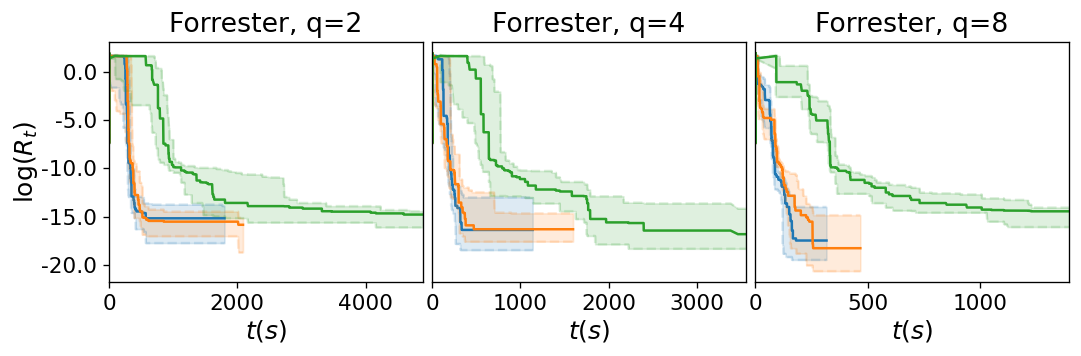

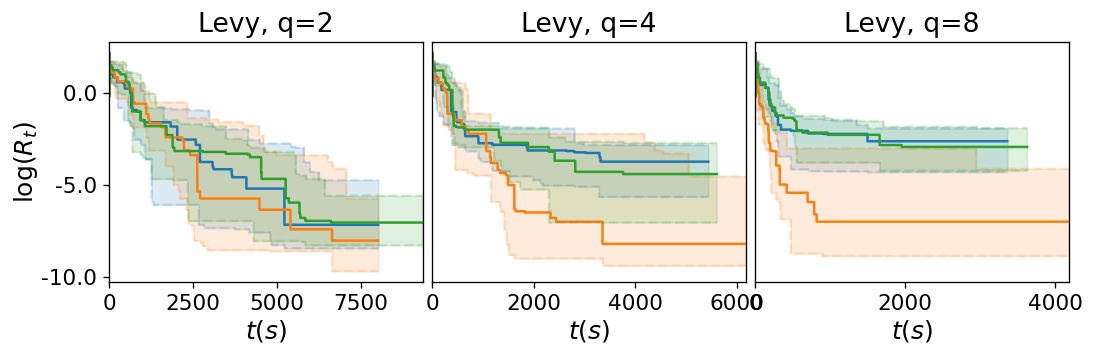

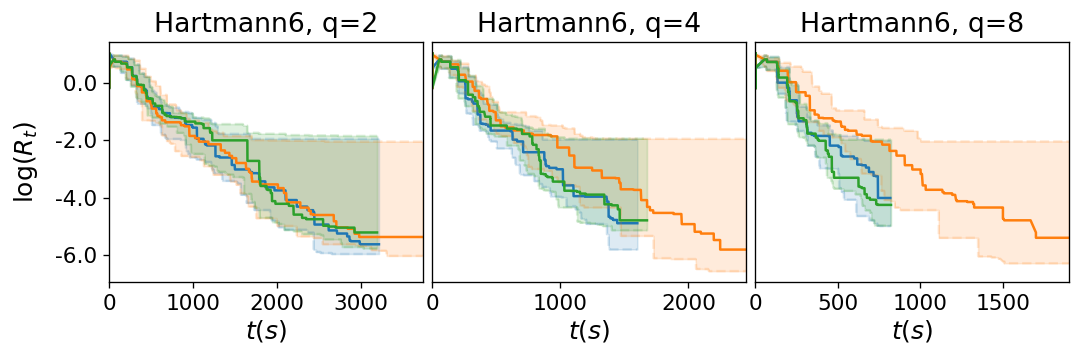

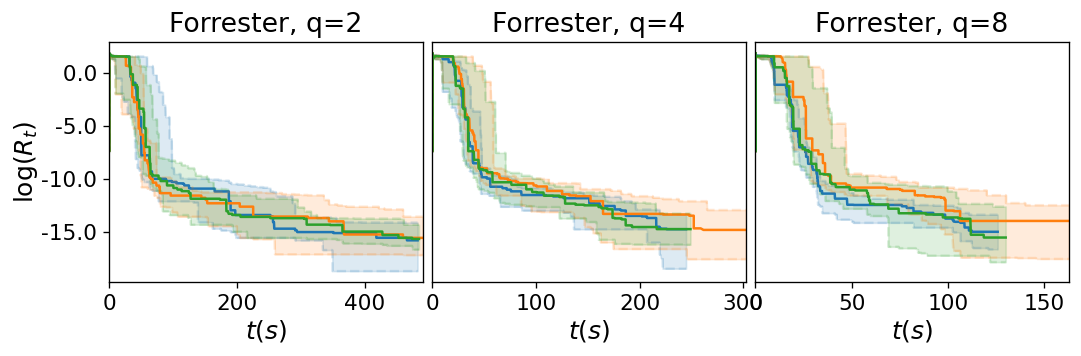

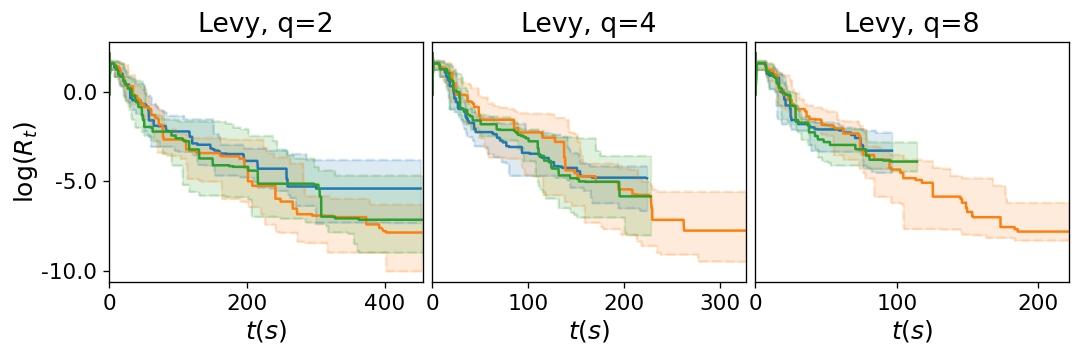

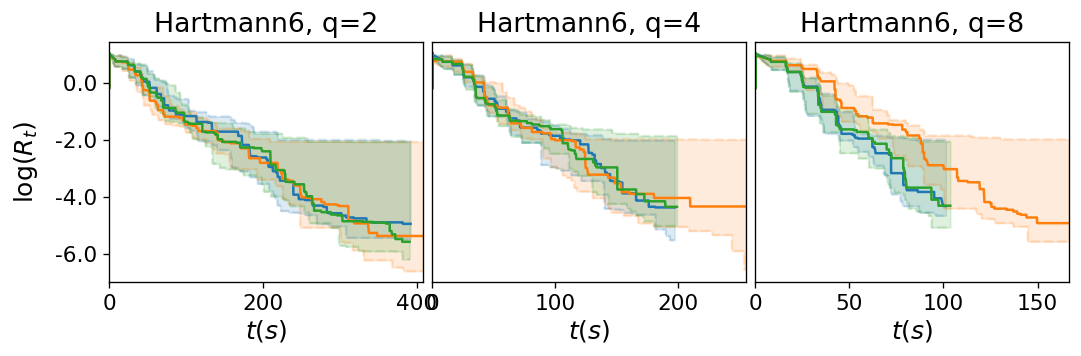

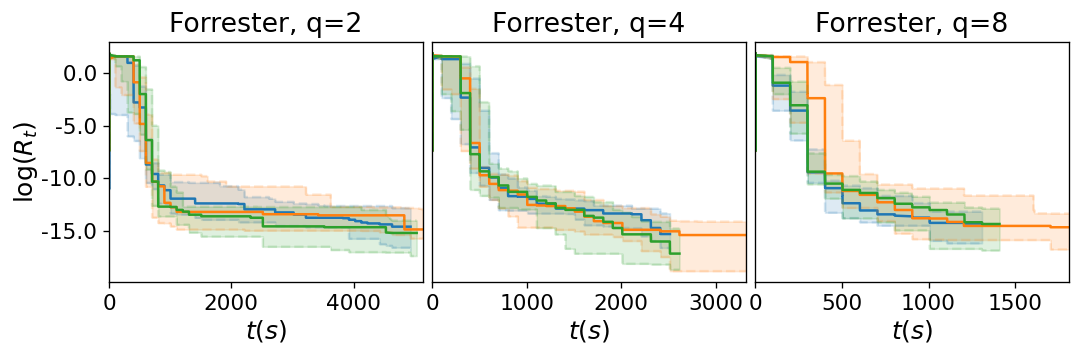

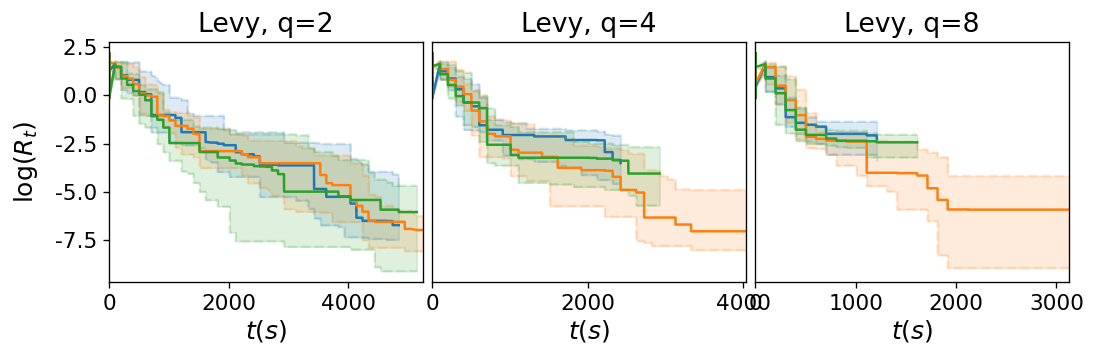

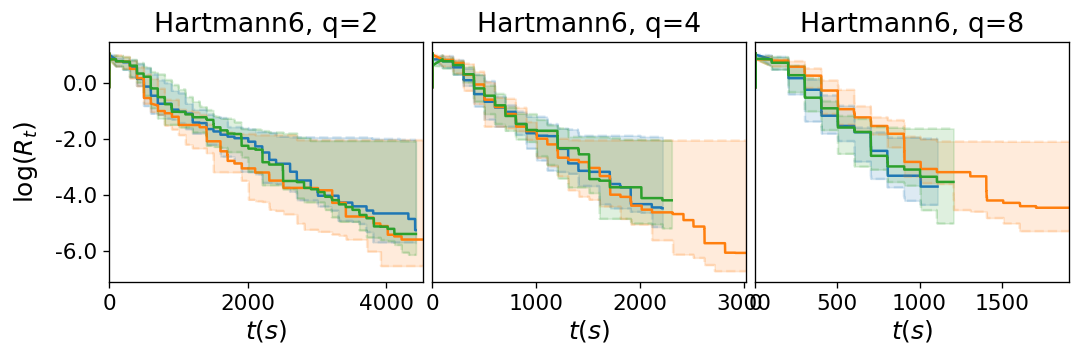

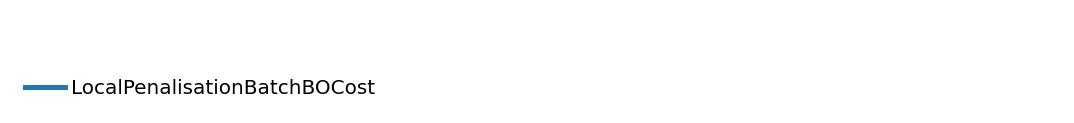

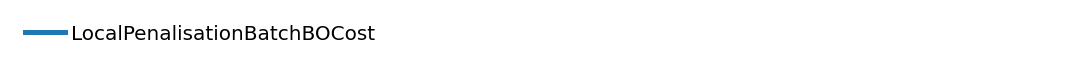

In [25]:
import aegis
from aegis import util
import numpy as np
import plotting

tag = False

list_methods = []

for acq_name in methods:

    _acq_name = acq_name

    if "d" in problem_params:
            problem_name = f'{problem_name:s}{problem_params["d"]:d}'

    if tag:
        if "DeterministicKilling" in kill_name:
            kill_name = f'{kill_name:s}{killing_params["delta"]:0.2f}'
        if "ProbabilisticKilling" in kill_name:
            kill_name = f'{kill_name:s}{killing_params["alpha"]:0.2f}'

    if "aegis" in acq_name:
        epsilon = acq_params["epsilon"]
        try:
            eta = acq_params["eta"]
        except KeyError:
            eta = 0.5

        try:
            epsilon = f"{float(epsilon):0.2f}"
        except ValueError:
            pass
        acq_name = f"{acq_name:s}-{epsilon:s}"

        if eta != 0.5:
            acq_name += f"-{float(eta):g}"

    if "BatchBO" in acq_name:
        acq_name = f'{acq_name:s}-{acq_params["acq_name"]:s}'

    list_methods.append(acq_name)
    bo_names[acq_name] = bo_names[_acq_name]

D = plotting.read_in_results(
    [time_func for time_func, _ in time_functions], workers, problems, list_methods, killing_names, num_runs, max_steps, bo_names
)

TITLE_FONTSIZE = 16#19
LABEL_FONTSIZE = 15#18
TICK_FONTSIZE = 13#16

method_cols = (
    np.array(
        [
            [31, 119, 180],
            [255, 127, 14],
            [44, 160, 44],
            [214, 39, 40],
            [148, 103, 189],
            [227, 119, 194],
        ]
    )
    / 255
)

for time_func, interface in time_functions:
    plotting.make_conv_plots(
        D,
        time_func,
        problems,
        workers,
        max_steps,
        list_methods,
        method_cols,
        killing_names,
        fname_prefix=None,
        TITLE_FONTSIZE=TITLE_FONTSIZE,
        LABEL_FONTSIZE=LABEL_FONTSIZE,
        TICK_FONTSIZE=TICK_FONTSIZE,
        savefig=False,
    )

# indices of the methods
# 0 Random
# 1 TS
# 2 KB
# 3 LP
# 4 PLaYBOOK
# 5 AEGiS-RS
# 6 AEGiS
aegis.plotting.make_legend(
    killing_names, 
    method_cols,
#     onecol_inds=[0, 1, 2, 5, 3, 6, 4],
#     twocol_inds=[0, 2, 3, 4, 1, 5, 6],
    onecol_inds=list(range(len(methods))),
    twocol_inds=list(range(len(methods))),
    savefig=False,
    fname_prefix=None,
)

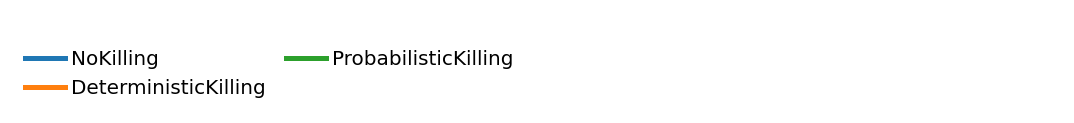

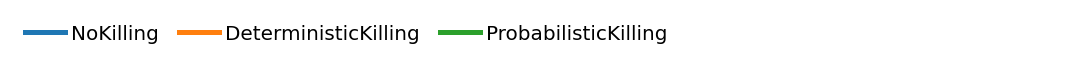

In [27]:
aegis.plotting.make_legend(
    killing_names, 
    method_cols,
#     onecol_inds=[0, 1, 2, 5, 3, 6, 4],
#     twocol_inds=[0, 2, 3, 4, 1, 5, 6],
    onecol_inds=list(range(len(killing_names))),
    twocol_inds=list(range(len(killing_names))),
    savefig=False,
    fname_prefix=None,
)